In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [3]:
import os

In [4]:
# target은 Disaster, Not Disaster Tweet 으로 분류
tweet= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [5]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


Text(0, 0.5, 'samples')

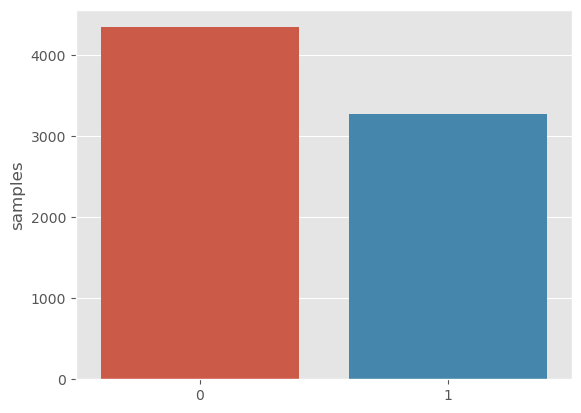

In [6]:
# Class distribution
# tweet 데이터프레임의 'target' 컬럼의 값 분포를 카운트합니다.
x = tweet.target.value_counts()
# x.index는 유니크한 'target' 값들이고, x.values는 각 값의 빈도수입니다.
sns.barplot(x=x.index, y=x.values)
plt.gca().set_ylabel('samples')

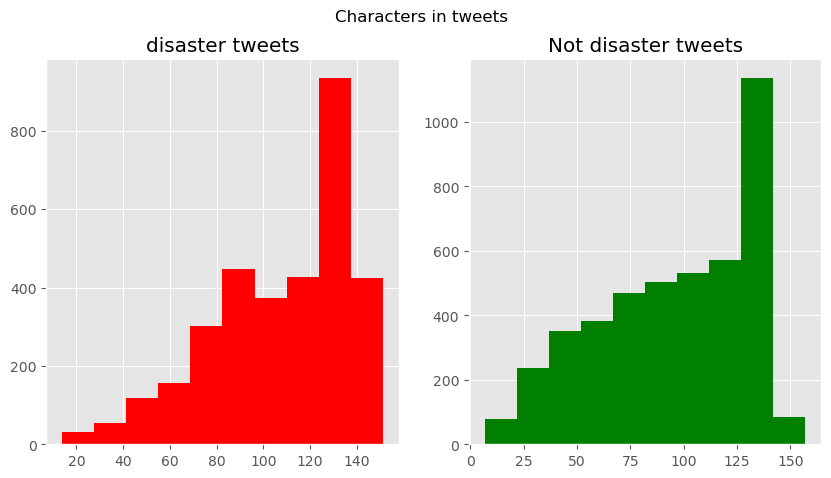

In [7]:
# Exploratory Data Analysis of tweets
# tweet 데이터프레임을 사용하여 'disaster tweets'와 'Not disaster tweets' 간의
# 텍스트 길이를 비교하기 위한 탐색적 데이터 분석(Exploratory Data Analysis, EDA)
# 0-disaster, 1-not disaster

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

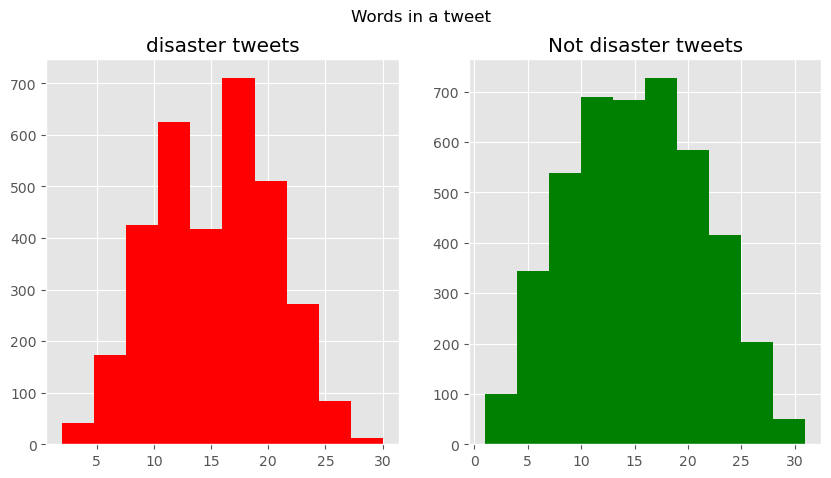

In [8]:
# Number of words in a tweet¶
# tweet 데이터프레임을 사용하여 'disaster tweets'와 'Not disaster tweets' 간에
# 트윗당 단어의 수를 비교하기 위한 탐색적 데이터 분석(Exploratory Data Analysis, EDA)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

/var/folders/3_/x71n0dfx597b2bmnkl6m82hm0000gn/T/ipykernel_7836/4143346937.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
/var/folders/3_/x71n0dfx597b2bmnkl6m82hm0000gn/T/ipykernel_7836/4143346937.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

Text(0.5, 0.98, 'Average word length in each tweet')

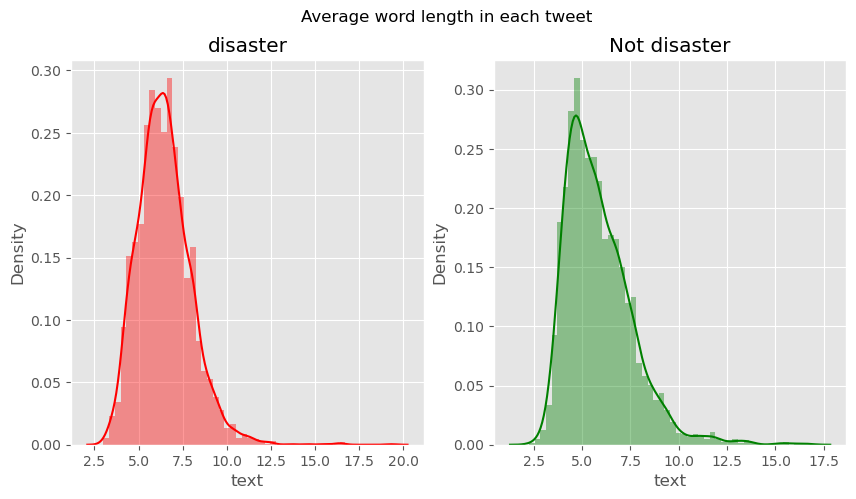

In [9]:
# Average word length in a tweet
#  tweet 데이터프레임을 사용하여 'disaster tweets'와
# 'Not disaster tweets' 간에 트윗당 평균 단어 길이를 비교하기 위한
# 탐색적 데이터 분석(Exploratory Data Analysis, EDA)을 수행

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [10]:
# tweet 데이터프레임의 target 값에 따른 모든 단어들의 목록(또는 corpus)을 생성
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [11]:
# Common stopwords in tweets
# tweet 데이터프레임에서 target 값이 0인 트윗들의 텍스트에서
# 가장 흔하게 등장하는 불용어(stopwords)를 찾는 역할

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

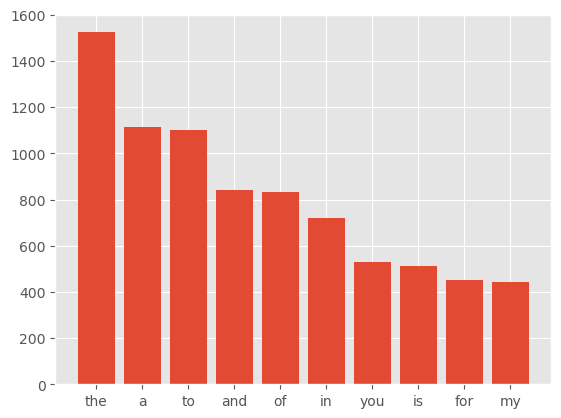

In [12]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

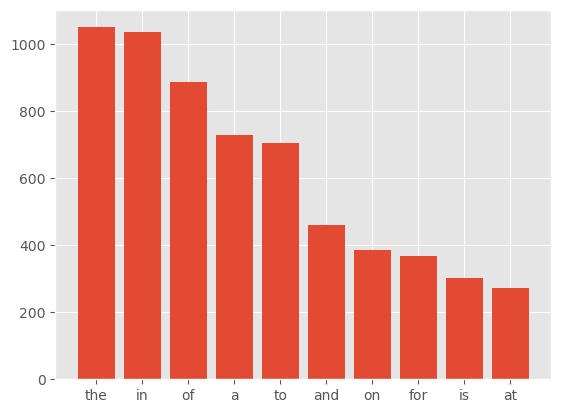

In [13]:
# tweet 데이터프레임에서 target 값이 1인 트윗들의
# 텍스트에서 가장 흔하게 등장하는 불용어(stopwords)를 찾고, 그것을 바 차트로 시각화하는 역할
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

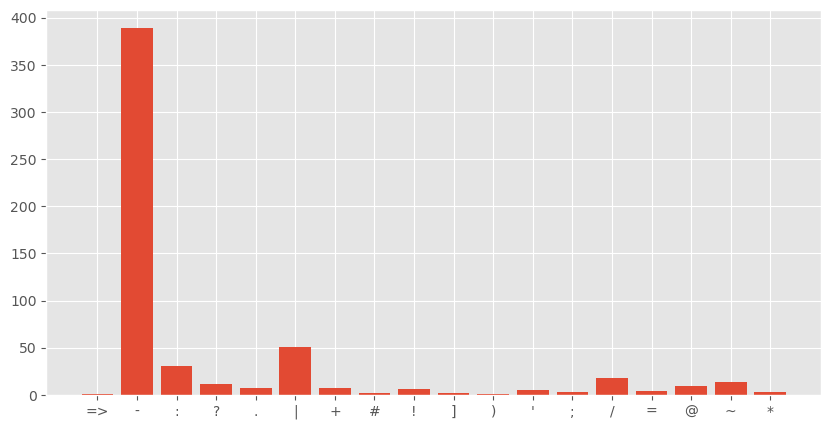

In [14]:
# Analyzing punctuations.
#  tweet 데이터프레임에서 target 값이 1인 트윗들의 텍스트에서
# 특수문자(구두점)의 등장 빈도를 분석하고, 그 결과를 바 차트로 시각화
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

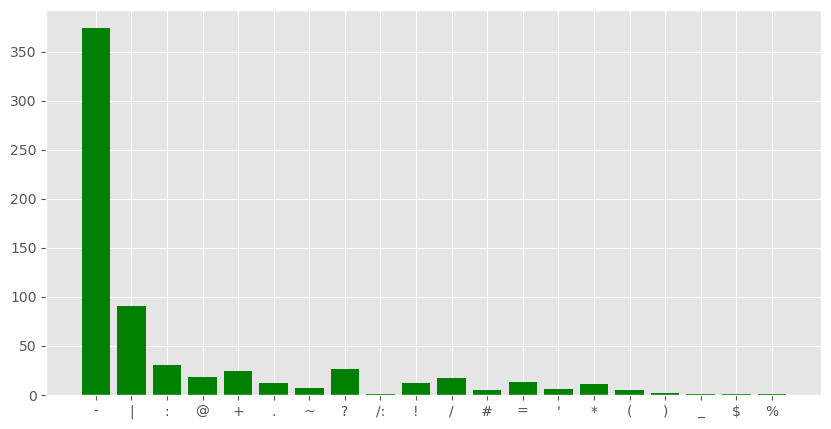

In [15]:
# tweet 데이터프레임에서 target 값이 0인 트윗들의
# 텍스트에서 특수문자(구두점)의 등장 빈도를 분석하고, 그 결과를 초록색 바 차트로 시각화

plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [16]:
# tweet 데이터프레임에서 target 값이 0인 트윗들의
# 텍스트에서 가장 흔하게 등장하는 단어들을 찾는 역할. 불용어(stopwords)는 제외
# common words
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Axes: >

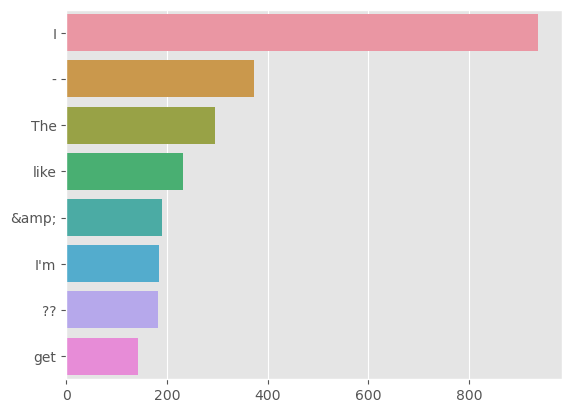

In [17]:
sns.barplot(x=y,y=x)

In [18]:
# 주어진 텍스트(corpus)의 바이그램(bigrams, 연속된 두 단어의 조합) 분석을 수행하고,
# 가장 빈번하게 등장하는 바이그램을 반환
# Ngram analysis
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

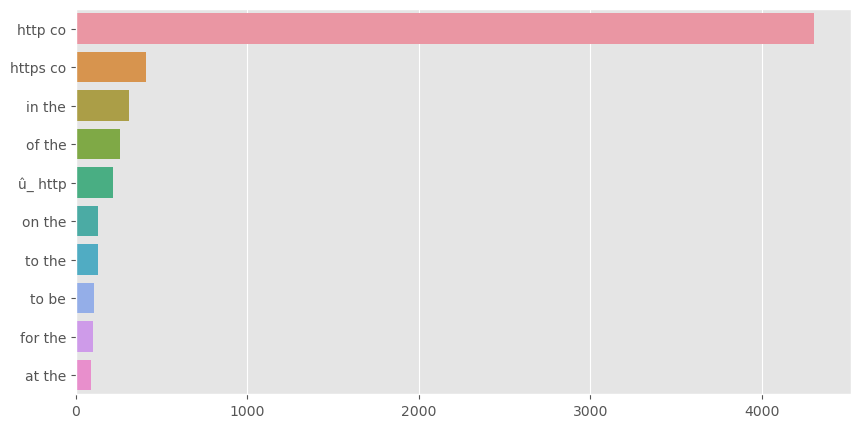

In [19]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [20]:
# Data Cleaning
# tweet 데이터프레임과 test 데이터프레임을 수직으로 결합 후 하나의 데이터프레임 df를 생성
# 그 결과 데이터프레임의 형태(shape)를 출력
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [21]:
# Removing urls
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [22]:
# URL Tag 제거
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [23]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [24]:
# Removing HTML tags
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [25]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [26]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [27]:
# Romoving Emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [28]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [29]:
# Removing punctuations, 주어진 구두점 제거
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [30]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [31]:
pip install pyspellchecker

Note: you may need to restart the kernel to use updated packages.


In [32]:
# 텍스트의 철자 오류를 수정하는 함수
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [33]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x)#)

In [34]:
# GloVe for Vectorization
# 전처리 하여 corpus(단어의 집합)을 생성

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [35]:
corpus=create_corpus(df)

100%|██████████████████████████████████| 10876/10876 [00:00<00:00, 19449.92it/s]


In [38]:
# GloVe (Global Vectors for Word Representation)의 사전 훈련된 단어 벡터를 로드

embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [39]:
# corpus를 토큰화하고 각 텍스트를 고정 길이의 숫자 시퀀스로 변환

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [40]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [41]:
# Keras Tokenizer로부터 얻은 단어 인덱스(word_index)와 GloVe의 사전 훈련된 임베딩(embedding_dict)
# 사용하여 각 단어에 대한 임베딩 행렬(embedding_matrix)을 구성

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|█████████████████████████████████| 20342/20342 [00:00<00:00, 407654.86it/s]


In [42]:
# Baseline Model
# Keras를 사용하여 기본 LSTM 기반의 딥러닝 모델을 구축
# GloVe로부터 얻은 단어 임베딩을 사용하여 문장을 벡터로 변환하고, 이를 LSTM 레이어에 입력

model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2034300   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2076605 (7.92 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 2034300 (7.76 MB)
_________________________________________________________________


In [44]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]


In [45]:
# 데이터셋 분할 & 학습
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [46]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)


Epoch 1/15
1618/1618 - 35s - loss: 0.6905 - accuracy: 0.5698 - val_loss: 0.6753 - val_accuracy: 0.5727 - 35s/epoch - 22ms/step
Epoch 2/15
1618/1618 - 34s - loss: 0.5941 - accuracy: 0.7092 - val_loss: 0.5418 - val_accuracy: 0.7592 - 34s/epoch - 21ms/step
Epoch 3/15
1618/1618 - 34s - loss: 0.5434 - accuracy: 0.7506 - val_loss: 0.5189 - val_accuracy: 0.7627 - 34s/epoch - 21ms/step
Epoch 4/15
1618/1618 - 34s - loss: 0.5209 - accuracy: 0.7623 - val_loss: 0.5023 - val_accuracy: 0.7732 - 34s/epoch - 21ms/step
Epoch 5/15
1618/1618 - 34s - loss: 0.5134 - accuracy: 0.7707 - val_loss: 0.4927 - val_accuracy: 0.7820 - 34s/epoch - 21ms/step
Epoch 6/15
1618/1618 - 34s - loss: 0.5039 - accuracy: 0.7781 - val_loss: 0.4857 - val_accuracy: 0.7863 - 34s/epoch - 21ms/step
Epoch 7/15
1618/1618 - 34s - loss: 0.5003 - accuracy: 0.7761 - val_loss: 0.4805 - val_accuracy: 0.7837 - 34s/epoch - 21ms/step
Epoch 8/15
1618/1618 - 34s - loss: 0.4993 - accuracy: 0.7769 - val_loss: 0.4777 - val_accuracy: 0.7846 - 34s/ep

In [47]:
# f1 score를 계산합니다.
from sklearn.metrics import f1_score

# 모델을 사용하여 예측합니다.
y_pre = model.predict(X_test)
y_pre = np.round(y_pre).astype(int).reshape(len(X_test))

f1 = f1_score(y_test, y_pre)
print(f"F1 Score: {f1}")

36/36 [==============================] - 0s 5ms/step
F1 Score: 0.7558386411889596
